In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("."))))

from simulation import simulation
from simulation.mm1_sim import mm1_sim

In [4]:
from simulation.mm1_sim import mm1_sim

**M/M/1 validation (No batching, c=0, exponential service)**

In [5]:
lambda_rate = 0.5
mu = 1.0

res = mm1_sim(lambda_rate=lambda_rate, mu=mu, num_jobs=5000)
res

rho = lambda_rate / mu
Wq_theory = rho / (mu - lambda_rate)
W_theory  = 1 / (mu - lambda_rate)

print("M/M/1 VALIDATION\n")
print(f"lambda = {lambda_rate}, mu = {mu}, rho = {rho:.2f}\n")
print(f"Simulated Average Wait:   {res['avg_wait']:.3f}")
print(f"Theoretical Average Wait: {Wq_theory:.3f}\n")
print(f"Simulated System Time:    {res['avg_system']:.3f}")
print(f"Theoretical System Time:  {W_theory:.3f}")


M/M/1 VALIDATION

lambda = 0.5, mu = 1.0, rho = 0.50

Simulated Average Wait:   1.138
Theoretical Average Wait: 1.000

Simulated System Time:    2.145
Theoretical System Time:  2.000


**Baseline and Prefill-First Schedulers**

In [6]:
results = {}

res_baseline = simulation.run_experiment(
    mode="baseline",
    seed=42,
    num_jobs=40,
    arrival_rate=0.5,
    sim_time=100.0,
)
results["baseline"] = res_baseline

res_prefill = simulation.run_experiment(
    mode="prefill_first",
    seed=42,
    num_jobs=40,
    arrival_rate=0.5,
    sim_time=100.0,
)
results["prefill_first"] = res_prefill

results

 2.040 - Query_1 arrives
 2.091 - Query_2 arrives
 2.734 - Query_3 arrives
 2.996 - Query_1 finishes

 3.239 - Query_4 arrives
 3.951 - Query_2 finishes

 4.907 - Query_3 finishes

 5.862 - Query_4 finishes

 5.906 - Query_5 arrives
 6.862 - Query_5 finishes

 8.165 - Query_6 arrives
 9.120 - Query_6 finishes

12.619 - Query_7 arrives
12.801 - Query_8 arrives
13.575 - Query_7 finishes

13.897 - Query_9 arrives
13.958 - Query_10 arrives
14.451 - Query_11 arrives
14.530 - Query_8 finishes

15.486 - Query_9 finishes

15.859 - Query_12 arrives
15.913 - Query_13 arrives
16.356 - Query_14 arrives
16.441 - Query_10 finishes

17.397 - Query_11 finishes

18.352 - Query_12 finishes

18.455 - Query_15 arrives
19.308 - Query_13 finishes

20.030 - Query_16 arrives
20.263 - Query_14 finishes

20.528 - Query_17 arrives
21.219 - Query_15 finishes

22.174 - Query_16 finishes

22.308 - Query_18 arrives
23.130 - Query_17 finishes

24.085 - Query_18 finishes

25.623 - Query_19 arrives
25.636 - Query_20 ar

{'baseline': {'mode': 'baseline',
  'throughput': 0.5486420603644793,
  'avg_ttft': 0.6855124099382495,
  'avg_tbt': 0.04549999999999954,
  'total_time': 72.9072794262744,
  'completed_queries': [<simulation.query.Query at 0x115b6a110>,
   <simulation.query.Query at 0x115b6a440>]},
 'prefill_first': {'mode': 'prefill_first',
  'throughput': 0.5484908454840636,
  'avg_ttft': 0.058184909774796664,
  'avg_tbt': 0.06769605263157837,
  'total_time': 72.92737942544603,
  'completed_queries': [<simulation.query.Query at 0x115b6af20>,
   <simulation.query.Query at 0x115b85e70>]}}

In [7]:
results["prefill_first"]

{'mode': 'prefill_first',
 'throughput': 0.5484908454840636,
 'avg_ttft': 0.058184909774796664,
 'avg_tbt': 0.06769605263157837,
 'total_time': 72.92737942544603,
 'completed_queries': [<simulation.query.Query at 0x115b6af20>,
  <simulation.query.Query at 0x115b85e70>]}

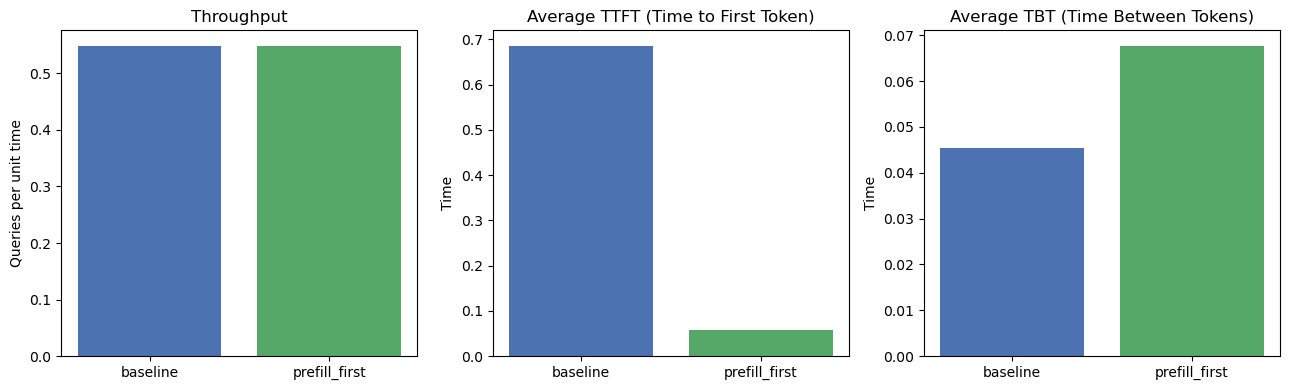

In [8]:
import matplotlib.pyplot as plt

modes = ["baseline", "prefill_first"]

throughputs = [results[m]["throughput"] for m in modes]
ttfts = [results[m]["avg_ttft"] for m in modes]
tbts = [results[m]["avg_tbt"] for m in modes]

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Throughput
axes[0].bar(modes, throughputs, color=["#4C72B0", "#55A868"])
axes[0].set_title("Throughput")
axes[0].set_ylabel("Queries per unit time")

# TTFT
axes[1].bar(modes, ttfts, color=["#4C72B0", "#55A868"])
axes[1].set_title("Average TTFT (Time to First Token)")
axes[1].set_ylabel("Time")

# TBT
axes[2].bar(modes, tbts, color=["#4C72B0", "#55A868"])
axes[2].set_title("Average TBT (Time Between Tokens)")
axes[2].set_ylabel("Time")

plt.tight_layout()
plt.show()


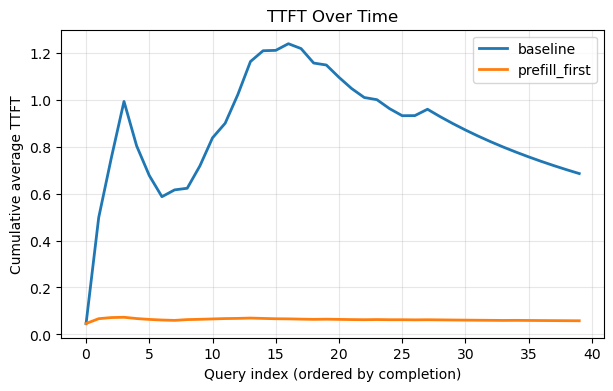

In [9]:
def cumulative_ttft(completed_queries):
    qs = sorted(completed_queries, key=lambda q: q.finish_time)
    vals = []
    cum = 0.0
    n = 0
    for q in qs:
        if q.prefill_done_time is None:
            continue
        ttft = q.prefill_done_time - q.arrival_time
        n += 1
        cum += ttft
        vals.append(cum / n)
    return vals

series_baseline = cumulative_ttft(results["baseline"]["completed_queries"])
series_prefill = cumulative_ttft(results["prefill_first"]["completed_queries"])

plt.figure(figsize=(7, 4))
plt.plot(series_baseline, label="baseline", linewidth=2)
plt.plot(series_prefill, label="prefill_first", linewidth=2)
plt.xlabel("Query index (ordered by completion)")
plt.ylabel("Cumulative average TTFT")
plt.title("TTFT Over Time")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


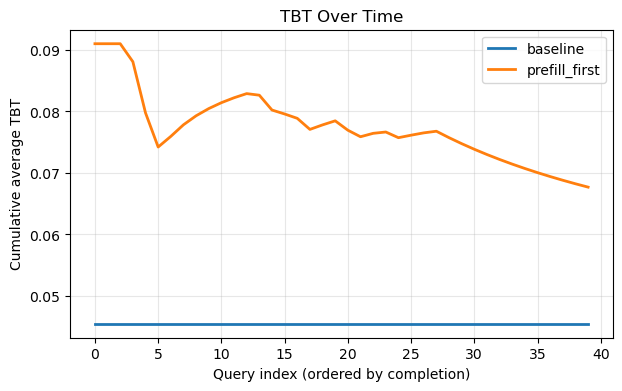

In [10]:
def cumulative_tbt(completed_queries):
    vals = []
    cum = 0.0
    n = 0
    for q in completed_queries:
        times = q.decode_token_times
        if len(times) >= 2:
            gaps = [t2 - t1 for t1, t2 in zip(times[:-1], times[1:])]
            avg_gap = sum(gaps) / len(gaps)
            cum += avg_gap
            n += 1
            vals.append(cum / n)
    return vals

series_tbt_baseline = cumulative_tbt(results["baseline"]["completed_queries"])
series_tbt_prefill = cumulative_tbt(results["prefill_first"]["completed_queries"])

plt.figure(figsize=(7, 4))
plt.plot(series_tbt_baseline, label="baseline", linewidth=2)
plt.plot(series_tbt_prefill, label="prefill_first", linewidth=2)
plt.xlabel("Query index (ordered by completion)")
plt.ylabel("Cumulative average TBT")
plt.title("TBT Over Time")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
